<!--<badge>--><a href="https://colab.research.google.com/github/Deep-Learning-IGP-TUBS-SoSe2022/2022-Group06/blob/main/Assignments/07_different_arch_for_segmentation/Resnet18_backbone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

In [7]:
running_on_google = False

if running_on_google:
    from google.colab import drive
    drive.mount('/content/drive')


In [5]:
!pip install -U segmentation-models

  Attempting uninstall: image-classifiers
    Found existing installation: image-classifiers 0.2.0
    Uninstalling image-classifiers-0.2.0:
      Successfully uninstalled image-classifiers-0.2.0
  Attempting uninstall: segmentation-models
    Found existing installation: segmentation-models 0.2.1
    Uninstalling segmentation-models-0.2.1:
      Successfully uninstalled segmentation-models-0.2.1


In [8]:
import os
import segmentation_models as sm

location = '/content/drive/MyDrive/ISPRS_semantic_labeling_Vaihingen' if running_on_google else 'ISPRS_semantic_labeling_Vaihingen' 
dirs = os.listdir(location)
assert 'gts' in dirs, 'expected file not found'
assert 'dsm' in dirs, 'expected file not found'
assert 'top' in dirs, 'expected file not found'


In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.metrics import OneHotMeanIoU, OneHotIoU
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
# Operation with arrays
import numpy as np
# Paths and files
from os.path import join,basename,splitext
import os
from glob import glob
from natsort import natsorted
# Reading images
import tifffile
from PIL import Image
# Others
import random

print(tf.config.list_physical_devices('GPU'))
keras.backend.set_image_data_format('channels_last')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
# Path to the dataset folder in Google Drive
root_path = location
path_top = join(root_path,"top")
path_dsm = join(root_path,"dsm")
path_gts = join(root_path,"gts")

# List with all TIF images in each folder
list_top = glob(join(path_top,"*.tif"))
list_top = natsorted(list_top, key=lambda y: y.lower())

list_dsm = glob(join(path_dsm,"*.tif"))
list_dsm = natsorted(list_dsm, key=lambda y: y.lower())

list_gts = glob(join(path_gts,"*.tif"))
list_gts = natsorted(list_gts, key=lambda y: y.lower())

In [11]:
# Images IDs for train and test
train_ids = [1,3,5,7,11,13,15,17,21,23,26,28,30,32,34,37]
test_ids = [2,4,6,8,10,12,14,16,20,22,24,27,29,31,33,35,38]

list_top_train, list_top_val, list_top_test = ([] for i in range(3))
list_dsm_train, list_dsm_val, list_dsm_test = ([] for i in range(3))
list_gts_train, list_gts_val, list_gts_test = ([] for i in range(3))

In [12]:
for top,dsm,gts in zip(list_top,list_dsm,list_gts):
  # Get the aread ID from the filename
  area_id = int(splitext(basename(top))[0].split("area")[-1])
  # Train set
  if area_id in train_ids:    
    list_top_train.append(top)
    list_dsm_train.append(dsm)
    list_gts_train.append(gts)
  # Test set
  elif area_id in test_ids:    
    list_top_test.append(top)
    list_dsm_test.append(dsm)
    list_gts_test.append(gts)

# shuffle train lists
temp = list(zip(list_top_train,list_dsm_train,list_gts_train))
random.seed(10)
random.shuffle(temp)
list_top_train,list_dsm_train,list_gts_train = zip(*temp)

# take 25% as validation set
p_val = 0.25
n_val = int(p_val*len(list_top_train))

list_top_val = list_top_train[:n_val]
list_top_train = list_top_train[n_val:]

list_dsm_val = list_dsm_train[:n_val]
list_dsm_train = list_dsm_train[n_val:]

list_gts_val = list_gts_train[:n_val]
list_gts_train = list_gts_train[n_val:]

In [13]:
def print_info(list_top,list_dsm,list_gts):
  for top,dsm,gts in zip(list_top,list_dsm,list_gts):
    gt_temp = tifffile.imread(gts)
    n_classes = len(np.unique(gt_temp.reshape(gt_temp.shape[0]*gt_temp.shape[1],-1),axis=0))
    print("TOP:{} , DSM:{} , GT:{} , N:{}".format(basename(top),
                                  basename(dsm),
                                  basename(gts),
                                  n_classes))

In [14]:
# Train
print("Train:")
print_info(list_top_train,list_dsm_train,list_gts_train)

# Validation
print("\nValidation:")
print_info(list_top_val,list_dsm_val,list_gts_val)

# Test
print("\nTest:")
print_info(list_top_test,list_dsm_test,list_gts_test)

Train:
TOP:top_mosaic_09cm_area28.tif , DSM:dsm_09cm_matching_area28.tif , GT:top_mosaic_09cm_area28.tif , N:6
TOP:top_mosaic_09cm_area37.tif , DSM:dsm_09cm_matching_area37.tif , GT:top_mosaic_09cm_area37.tif , N:5
TOP:top_mosaic_09cm_area13.tif , DSM:dsm_09cm_matching_area13.tif , GT:top_mosaic_09cm_area13.tif , N:5
TOP:top_mosaic_09cm_area11.tif , DSM:dsm_09cm_matching_area11.tif , GT:top_mosaic_09cm_area11.tif , N:5
TOP:top_mosaic_09cm_area30.tif , DSM:dsm_09cm_matching_area30.tif , GT:top_mosaic_09cm_area30.tif , N:5
TOP:top_mosaic_09cm_area32.tif , DSM:dsm_09cm_matching_area32.tif , GT:top_mosaic_09cm_area32.tif , N:6
TOP:top_mosaic_09cm_area7.tif , DSM:dsm_09cm_matching_area7.tif , GT:top_mosaic_09cm_area7.tif , N:5
TOP:top_mosaic_09cm_area1.tif , DSM:dsm_09cm_matching_area1.tif , GT:top_mosaic_09cm_area1.tif , N:6
TOP:top_mosaic_09cm_area23.tif , DSM:dsm_09cm_matching_area23.tif , GT:top_mosaic_09cm_area23.tif , N:6
TOP:top_mosaic_09cm_area17.tif , DSM:dsm_09cm_matching_area17.t

Image: ISPRS_semantic_labeling_Vaihingen\top\top_mosaic_09cm_area20.tif


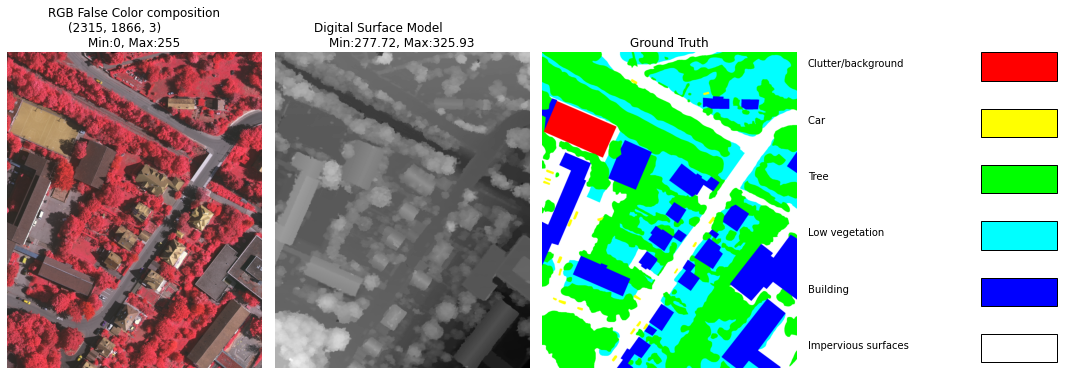

In [15]:
#@title Samples Visualization { run: "auto"}
#@markdown Select a sample
id_sample = 16 #@param {type:"slider", min:0, max:32, step:1}
img_top = tifffile.imread(list_top[id_sample])
img_dsm = tifffile.imread(list_dsm[id_sample])

print("Image: {}".format(list_top[id_sample]))

plt.figure(figsize=(15,5))

plt.subplot(1,4,1)
plt.imshow(img_top)
plt.title("RGB False Color composition\n{}\
          \nMin:{}, Max:{}".format(img_top.shape,
                                     img_top.min(),
                                     img_top.max()))
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(img_dsm, cmap="gray")
plt.title("Digital Surface Model\
            \nMin:{:.2f}, Max:{:.2f}".format(img_dsm.min(),
                                             img_dsm.max()))
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(tifffile.imread(list_gts[id_sample]))
plt.title("Ground Truth")
plt.axis("off")

g = plt.subplot(1,4,4)
g.axes.set_xlim(0,3.4)
g.axes.set_ylim(-0.01,0.55)

g.text(0, 0.025, "Impervious surfaces")
g.text(0, 0.125, "Building ")
g.text(0, 0.225, "Low vegetation")
g.text(0, 0.325, "Tree ")
g.text(0, 0.425, "Car ")
g.text(0, 0.525, "Clutter/background")

x_rec = 2.3
g.add_patch(patches.Rectangle((x_rec,0.0), 1, 0.05, facecolor="#FFFFFF", edgecolor="black"))
g.add_patch(patches.Rectangle((x_rec,0.1), 1, 0.05, facecolor="#0000FF", edgecolor="black"))
g.add_patch(patches.Rectangle((x_rec,0.2), 1, 0.05, facecolor="#00FFFF", edgecolor="black"))
g.add_patch(patches.Rectangle((x_rec,0.3), 1, 0.05, facecolor="#00FF00", edgecolor="black"))
g.add_patch(patches.Rectangle((x_rec,0.4), 1, 0.05, facecolor="#FFFF00", edgecolor="black"))
g.add_patch(patches.Rectangle((x_rec,0.5), 1, 0.05, facecolor="#FF0000", edgecolor="black"))
g.axis("off")

plt.tight_layout()
plt.show()

In [16]:
color2index = {(255,255,255) : 0,
               (0  ,0  ,255) : 1,
               (0  ,255,255) : 2,
               (0  ,255,0  ) : 3,
               (255,255,0  ) : 4,
               (255,0  ,0  ) : 5
               }
n_classes = len(color2index)

In [67]:
class DataGenerator(keras.utils.Sequence):
  def __init__(self,
               batch_size,
               patch_size,
               step_size,
               list_top,                
               list_gts,
               n_classes,
               colormap_gt=None,
               augmentation=None,
               preprocessing=None,
               backbone_preprocess=None,
               shuffle=True):
    self.batch_size = batch_size
    self.patch_size = patch_size
    self.step_size = step_size
    self.list_top = list_top    
    self.list_gts = list_gts
    self.n_classes = n_classes
    self.colormap_gt = colormap_gt
    self.augmentation = augmentation
    self.preprocessing = preprocessing        
    self.shuffle= shuffle
    self.path_coords = self.__get_path_coords()
    self.n_patchs = len(self.path_coords)
    self.backbone_preprocess = backbone_preprocess

  def __get_path_coords(self):
    path_coords = []    
    for path_image, path_label in zip(self.list_top,self.list_gts):       
      width, height = Image.open(path_label).size      
      for y in range(0, height, self.step_size):
        for x in range(0, width, self.step_size):
          if (x + self.patch_size) > width:
            x = width - self.patch_size
          if (y + self.patch_size) > height:
            y = height - self.patch_size
          
          path_coords.append((path_image, path_label, (x,y)))          
    return path_coords
        
  def on_epoch_end(self):
    if self.shuffle:
      random.shuffle(self.path_coords)

  def __len__(self):
    return np.ceil(self.n_patchs/self.batch_size).astype("int")

  def __get_patch_image(self, path_image, x, y):
    # Reading the RGB image
    data_image = Image.open(path_image)
    data_image = data_image.crop((x, y, 
                                  x + self.patch_size, y + self.patch_size))
    data_image = np.asarray(data_image).astype("float32")
    
    if self.backbone_preprocess is not None:
        data_image = self.backbone_preprocess(data_image)
    else:
        data_image = data_image / 255.0
        
    return data_image

  def __get_patch_mask(self, path, x, y):
    # Reading the mask
    data_mask = Image.open(path)
    data_mask = data_mask.crop((x, y, 
                                x + self.patch_size, y + self.patch_size))
    data_mask = np.asarray(data_mask)
    # Convert RGB image [H x W x 3] to label image [H x W x 1]
    data_mask_idx = np.zeros((data_mask.shape[0], 
                              data_mask.shape[1]), dtype=np.uint8)
    for key in self.colormap_gt:
      class_id = self.colormap_gt[key]
      key = np.array(key)
      # Assign an index to each color based on the colormap
      # (255,255,255) : 0
      # (0  ,0  ,255) : 1,...
      data_mask_idx[(data_mask[:,:,0] == key[0]) & 
                    (data_mask[:,:,1] == key[1]) & 
                    (data_mask[:,:,2] == key[2])] = class_id
    return data_mask_idx

  def __getitem__(self, idx):
    i = idx * self.batch_size
    
    current_batch_size = self.batch_size
    if (idx+1) == self.__len__():
      current_batch_size = len(self.path_coords[i:])

    # Batch of coordinates
    batch_path_coords = self.path_coords[i : i + current_batch_size]

    x = np.zeros((current_batch_size, 
                  self.patch_size, 
                  self.patch_size, 
                  3),
                  dtype=np.float32)

    y = np.zeros((current_batch_size,
                  self.patch_size, 
                  self.patch_size,
                  self.n_classes),
                  dtype=np.float32)

    for j, (path_image, path_label, (x_pos, y_pos)) in enumerate(batch_path_coords):
      # Get an individual image and its corresponding label
      x_sample = self.__get_patch_image(path_image, x_pos, y_pos)
      y_sample = self.__get_patch_mask(path_label, x_pos, y_pos)        
      
      # If there are augmentation transformations, apply them
      if self.augmentation is not None:
        augmented = self.augmentation()(image=x_sample, mask=y_sample)
        x_sample = augmented["image"]
        y_sample = augmented["mask"]
      # If there is a preprocessing function, apply it
      if self.preprocessing is not None:
        preprocessed = self.preprocessing(image=x_sample, mask=y_sample)
        x_sample = preprocessed['image']
        y_sample = preprocessed['mask']
      # Convert labels to one hot encoding
      y_sample = to_categorical(y_sample, self.n_classes)

      x[j,...] = x_sample
      y[j,...] = y_sample
    return x, y

(4, 256, 256, 3) (4, 256, 256, 6)


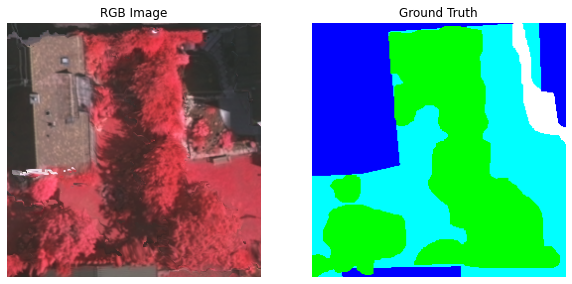

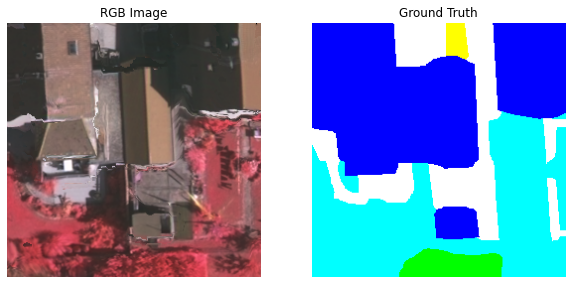

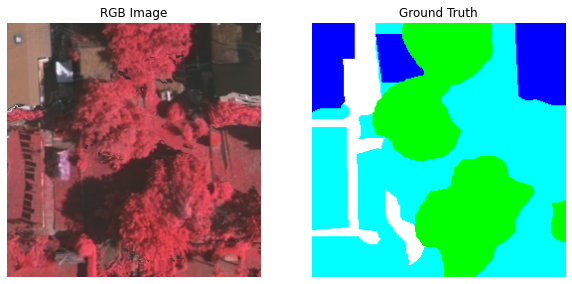

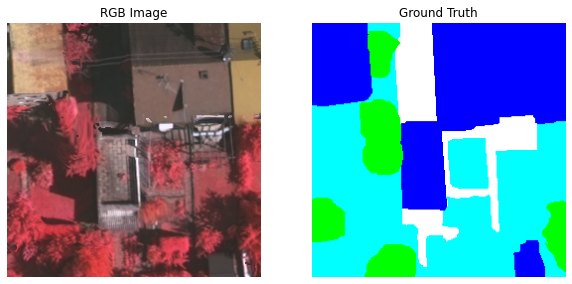

In [68]:
# Temporal generator
temp_generator = DataGenerator(batch_size=4,
                         patch_size=256,
                         step_size=256,
                         list_top=list_top_train, 
                         list_gts=list_gts_train,
                         n_classes=n_classes,
                         colormap_gt=color2index
                         )
# Iterate over all batches
for x,y in temp_generator:
  # Check the shape of the output of the generator
  print(x.shape, y.shape)
  for x_i,y_i in zip(x,y):
    # For visualization: [0,1] => [0,255]
    x_i = x_i*255
    # Apply argmax to convert from one hot to integers
    y_i = np.argmax(y_i, axis=-1)
    # Convert each class to a color given a colormap
    y_i_rgb = np.zeros((y_i.shape[0], y_i.shape[1], 3), dtype=np.uint8)
    for key,value in color2index.items():
      y_i_rgb[y_i==value] = key      
    # Visualization of RGB image and its ground truth or reference
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(x_i.astype("uint8"))
    plt.title("RGB Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(y_i_rgb, cmap="jet")
    plt.title("Ground Truth")
    plt.axis("off")
    plt.show()
  break

In [77]:
batch_size = 8
patch_size = 256
step_size = 256

BACKBONE = 'resnet18'
preprocess_input = sm.get_preprocessing(BACKBONE)

data_gen_train = DataGenerator(batch_size=batch_size,
                               patch_size=patch_size,
                               step_size=step_size,
                               list_top=list_top_train, 
                               list_gts=list_gts_train,
                               n_classes=n_classes,
                               colormap_gt=color2index,
                               backbone_preprocess=preprocess_input
                               )

data_gen_val = DataGenerator(batch_size=batch_size,
                             patch_size=patch_size,
                             step_size=step_size,
                             list_top=list_top_val, 
                             list_gts=list_gts_val,
                             n_classes=n_classes,
                             colormap_gt=color2index,
                             backbone_preprocess=preprocess_input
                             )                             

In [78]:
print("Train: {}, Validation: {}".format(len(data_gen_train), len(data_gen_val)))

Train: 128, Validation: 38


In [85]:
model_unet = sm.Unet(BACKBONE,
                     classes=6,
                     activation='softmax',
                     encoder_weights='imagenet',
                     encoder_freeze=True)

In [86]:
model_unet.compile(optimizer=Adam(),
                  loss="categorical_crossentropy",
                  metrics=["accuracy", OneHotMeanIoU(num_classes=n_classes, name="iou")])

In [87]:
def get_ckpt(ckpt_name):
    return ModelCheckpoint(ckpt_name,
                           mode="max", 
                           save_best_only=True, 
                           monitor="val_iou", 
                           verbose=1)

In [88]:
# Callbacks
# Checkpoint
autosave_unet = get_ckpt("segmentation_unet.h5")

# Early stopping
early_stopping = EarlyStopping(patience=30, verbose=1, mode = 'auto')

cbks_unet = [autosave_unet, early_stopping]

In [90]:
epochs = 50

In [91]:
history_unet = model_unet.fit(data_gen_train,
                              epochs=epochs,                                                     
                              validation_data=data_gen_val,                                                    
                              callbacks=cbks_unet,
                              workers=1, 
                              use_multiprocessing=False,
                              max_queue_size=20
                              )

Epoch 1/50
128/128 [==============================] - ETA: 0s - loss: 0.8272 - accuracy: 0.6938 - iou: 0.3605
Epoch 1: val_iou improved from -inf to 0.22709, saving model to segmentation_unet.h5
128/128 [==============================] - 49s 361ms/step - loss: 0.8272 - accuracy: 0.6938 - iou: 0.3605 - val_loss: 1.4142 - val_accuracy: 0.5143 - val_iou: 0.2271
Epoch 2/50
128/128 [==============================] - ETA: 0s - loss: 0.5834 - accuracy: 0.7750 - iou: 0.4747
Epoch 2: val_iou improved from 0.22709 to 0.36174, saving model to segmentation_unet.h5
128/128 [==============================] - 45s 352ms/step - loss: 0.5834 - accuracy: 0.7750 - iou: 0.4747 - val_loss: 0.9523 - val_accuracy: 0.6398 - val_iou: 0.3617
Epoch 3/50
128/128 [==============================] - ETA: 0s - loss: 0.5210 - accuracy: 0.8008 - iou: 0.5209
Epoch 3: val_iou did not improve from 0.36174
128/128 [==============================] - 45s 348ms/step - loss: 0.5210 - accuracy: 0.8008 - iou: 0.5209 - val_loss: 0

KeyboardInterrupt: 

In [96]:
from segmentation_models.utils import set_trainable

model_unet.load_weights("segmentation_unet.h5") # load the best fine tuned
set_trainable(model_unet)

model_unet.compile(optimizer=Adam(),
                  loss="categorical_crossentropy",
                  metrics=["accuracy", OneHotMeanIoU(num_classes=n_classes, name="iou")])

epochs = 20

# now release frozen weights and train little bit more
history_unet_2 = model_unet.fit(data_gen_train,
                                epochs=epochs,                                                     
                                validation_data=data_gen_val,                                                    
                                callbacks=cbks_unet,
                                workers=1, 
                                use_multiprocessing=False,
                                max_queue_size=20
                                )


Epoch 1/20
128/128 [==============================] - ETA: 0s - loss: 0.5023 - accuracy: 0.8102 - iou: 0.5398
Epoch 1: val_iou did not improve from 0.55535
128/128 [==============================] - 50s 370ms/step - loss: 0.5023 - accuracy: 0.8102 - iou: 0.5398 - val_loss: 0.7808 - val_accuracy: 0.7927 - val_iou: 0.4814
Epoch 2/20
128/128 [==============================] - ETA: 0s - loss: 0.4234 - accuracy: 0.8409 - iou: 0.5800
Epoch 2: val_iou did not improve from 0.55535
128/128 [==============================] - 47s 363ms/step - loss: 0.4234 - accuracy: 0.8409 - iou: 0.5800 - val_loss: 1.0245 - val_accuracy: 0.6930 - val_iou: 0.3976
Epoch 3/20
128/128 [==============================] - ETA: 0s - loss: 0.3920 - accuracy: 0.8504 - iou: 0.5886
Epoch 3: val_iou did not improve from 0.55535
128/128 [==============================] - 45s 353ms/step - loss: 0.3920 - accuracy: 0.8504 - iou: 0.5886 - val_loss: 0.5618 - val_accuracy: 0.8099 - val_iou: 0.5331
Epoch 4/20
128/128 [==============

In [97]:
data_gen_test = DataGenerator(batch_size=batch_size,
                              patch_size=patch_size,
                              step_size=step_size,
                              list_top=list_top_test, 
                              list_gts=list_gts_test,
                              n_classes=n_classes,
                              colormap_gt=color2index,
                              backbone_preprocess=preprocess_input
                              )

print("Train:")
scores_train = model_unet.evaluate(data_gen_train)

print("Validation:")
scores_val = model_unet.evaluate(data_gen_val)

print("Test:")
scores_test = model_unet.evaluate(data_gen_test)

Train:
128/128 [==============================] - 35s 272ms/step - loss: 0.1615 - accuracy: 0.9375 - iou: 0.7028
Validation:
38/38 [==============================] - 10s 259ms/step - loss: 0.8222 - accuracy: 0.8277 - iou: 0.5426
Test:
190/190 [==============================] - 57s 298ms/step - loss: 0.5514 - accuracy: 0.8369 - iou: 0.5600


1/1 [==============================] - 0s 432ms/step


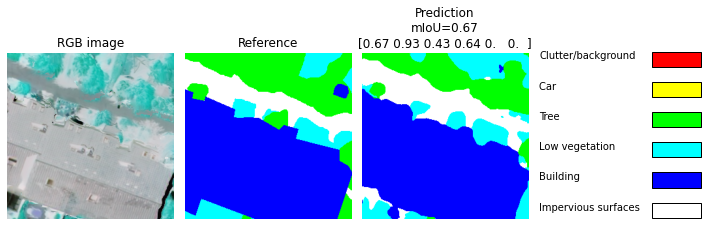

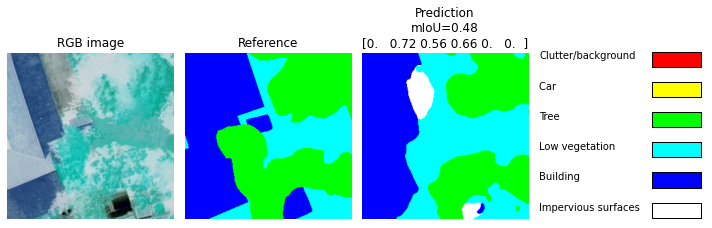

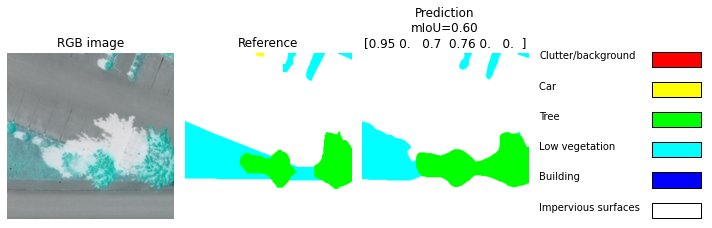

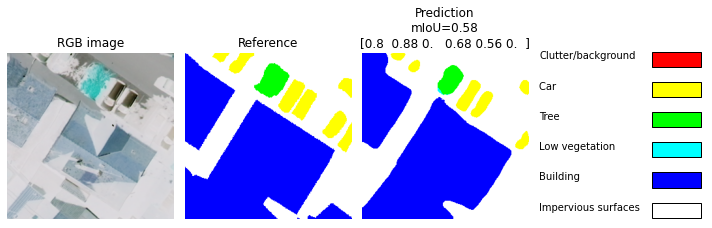

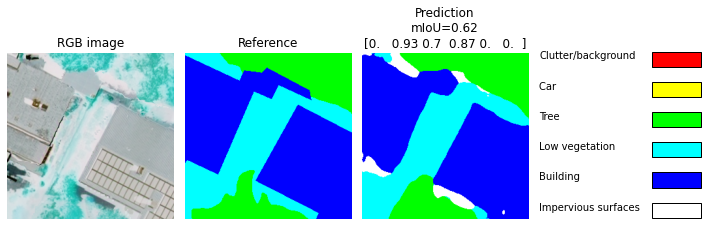

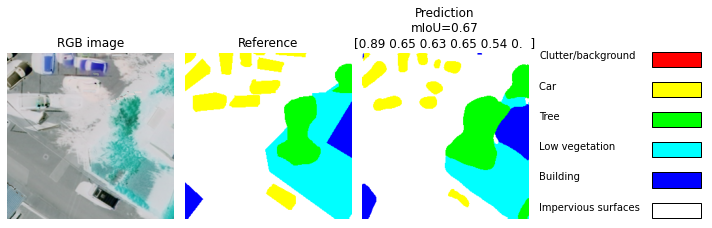

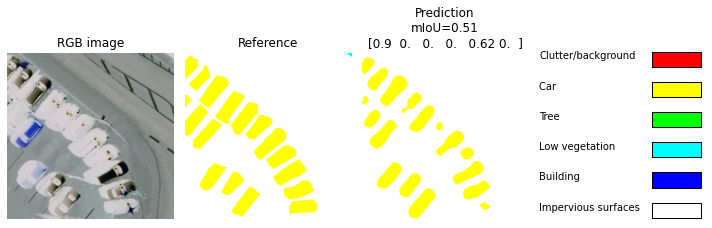

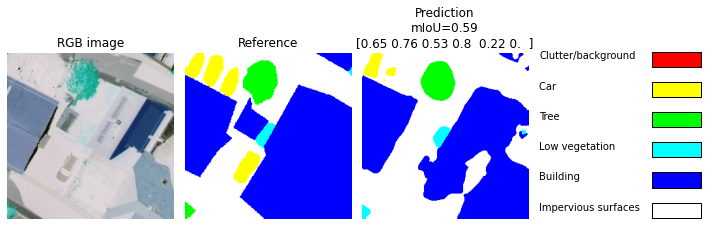

In [98]:
#@title Predictions Visualization { run: "auto"}
#@markdown Select a sample
id_batch = 107 #@param {type:"slider", min:0, max:189, step:1}

# Get a batch from the generator for testing
x,y = data_gen_test.__getitem__(id_batch)
# Obtain the prediction from the trained model
prediction = model_unet.predict(x)
# Iterate over each sample in the batch
for x_i,y_i,pred_i in zip(x,y,prediction):
  # For visualization: [0,1] => [0,255]
  x_i = x_i*255
  x_i = x_i.astype(np.uint8)
  # From one hot encoding to integer
  gt = np.argmax(y_i, axis=-1)
  pred = np.argmax(pred_i, axis=-1)
  # Object to compute the mean IoU
  m_iou = OneHotMeanIoU(num_classes=n_classes)
  m_iou.update_state(y_true=y_i, 
                     y_pred=pred_i)
  # List to storage IoU per class
  iou_all = []
  for id_class in range(n_classes):
    # Object to compute the IoU for each class
    m_iou_class = OneHotIoU(num_classes=n_classes, 
                            target_class_ids=[id_class])
    m_iou_class.update_state(y_true=y_i, 
                             y_pred=pred_i)
    # Save IoU for each class
    iou_all.append(m_iou_class.result().numpy())
  # Colo images for the Ground Truth and Prediction
  gt_rgb = np.zeros((gt.shape[0],gt.shape[1],3), dtype=np.uint8)
  pred_rgb = np.zeros((gt.shape[0],gt.shape[1],3), dtype=np.uint8)
  # Assign a color to each integer value from the given dictionary
  for key,value in color2index.items():
    gt_rgb[gt==value] = key
    pred_rgb[pred==value] = key
  # Visualization
  plt.figure(figsize=(10,3))
  plt.subplot(1,4,1)
  plt.imshow(x_i)
  plt.title("RGB image")
  plt.axis("off")

  plt.subplot(1,4,2)
  plt.imshow(gt_rgb)
  plt.title("Reference")
  plt.axis("off")

  plt.subplot(1,4,3)
  plt.imshow(pred_rgb)
  plt.title("Prediction\nmIoU={:.2f}\n{}".format(m_iou.result().numpy(),
                                                 np.round(iou_all, decimals=2)))
  plt.axis("off")

  g = plt.subplot(1,4,4)
  g.axes.set_xlim(0,3.4)
  g.axes.set_ylim(-0.01,0.55)

  g.text(0, 0.025, "Impervious surfaces")
  g.text(0, 0.125, "Building ")
  g.text(0, 0.225, "Low vegetation")
  g.text(0, 0.325, "Tree ")
  g.text(0, 0.425, "Car ")
  g.text(0, 0.525, "Clutter/background")

  x_rec = 2.3
  g.add_patch(patches.Rectangle((x_rec,0.0), 1, 0.05, facecolor="#FFFFFF", edgecolor="black"))
  g.add_patch(patches.Rectangle((x_rec,0.1), 1, 0.05, facecolor="#0000FF", edgecolor="black"))
  g.add_patch(patches.Rectangle((x_rec,0.2), 1, 0.05, facecolor="#00FFFF", edgecolor="black"))
  g.add_patch(patches.Rectangle((x_rec,0.3), 1, 0.05, facecolor="#00FF00", edgecolor="black"))
  g.add_patch(patches.Rectangle((x_rec,0.4), 1, 0.05, facecolor="#FFFF00", edgecolor="black"))
  g.add_patch(patches.Rectangle((x_rec,0.5), 1, 0.05, facecolor="#FF0000", edgecolor="black"))
  g.axis("off")

  plt.tight_layout()

  plt.show()
